# [LAB-10] 11. 이원분산분석(2way-anova) - 예제 (2) 

## #01. 준비작업

### 1. 패키지 참조:

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리:
from scipy.stats import t, normaltest, bartlett, levene

# 분산분석을 위한 라이브러리:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova, welch_anova

# 사후검정을 위한 라이브러리:
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

## #02. 예제2 - 측정자에 따른 태아의 머리둘레 측정 비교

다음 데이터는 3명의 태아를 대상으로 3명의 관측자가 측정한 자료이다.

측정자에 따라 태아의 머리둘레가 다르게 나타나는지 확인하라.

### 1. 데이터 가져오기:

In [3]:
origin = load_data('head_size')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/head_size.xlsx
[desc] 3명의 태아를 대상으로 3명의 관측자가 측정한 태아의 머리 둘레 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (60, 4)
열 갯수: 4
행 갯수: 60

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   측정자번호   60 non-null     int64  
 1   1번태아    60 non-null     float64
 2   2번태아    60 non-null     float64
 3   3번태아    60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB
None


,측정자번호,1번태아,2번태아,3번태아
0,1,14.9,19.7,13.0
1,1,14.4,20.7,13.5
2,1,14.4,19.9,13.2
3,1,15.1,20.2,12.8
4,1,15.4,19.4,13.8


### 2. 데이터 전처리

이원분산분석에 적합한 형태는 melt 처리된 표 형태임!

In [4]:
df = melt(origin, id_vars='측정자번호',
          value_vars=['1번태아', '2번태아', '3번태아'],
          var_name='태아번호', value_name='머리둘레')

df.head()

,측정자번호,태아번호,머리둘레
0,1,1번태아,14.9
1,1,1번태아,14.4
2,1,1번태아,14.4
3,1,1번태아,15.1
4,1,1번태아,15.4


### 3. 데이터 분포 시각화

#### (1) 측정자 별 태아에 따른 머리둘레 비교:

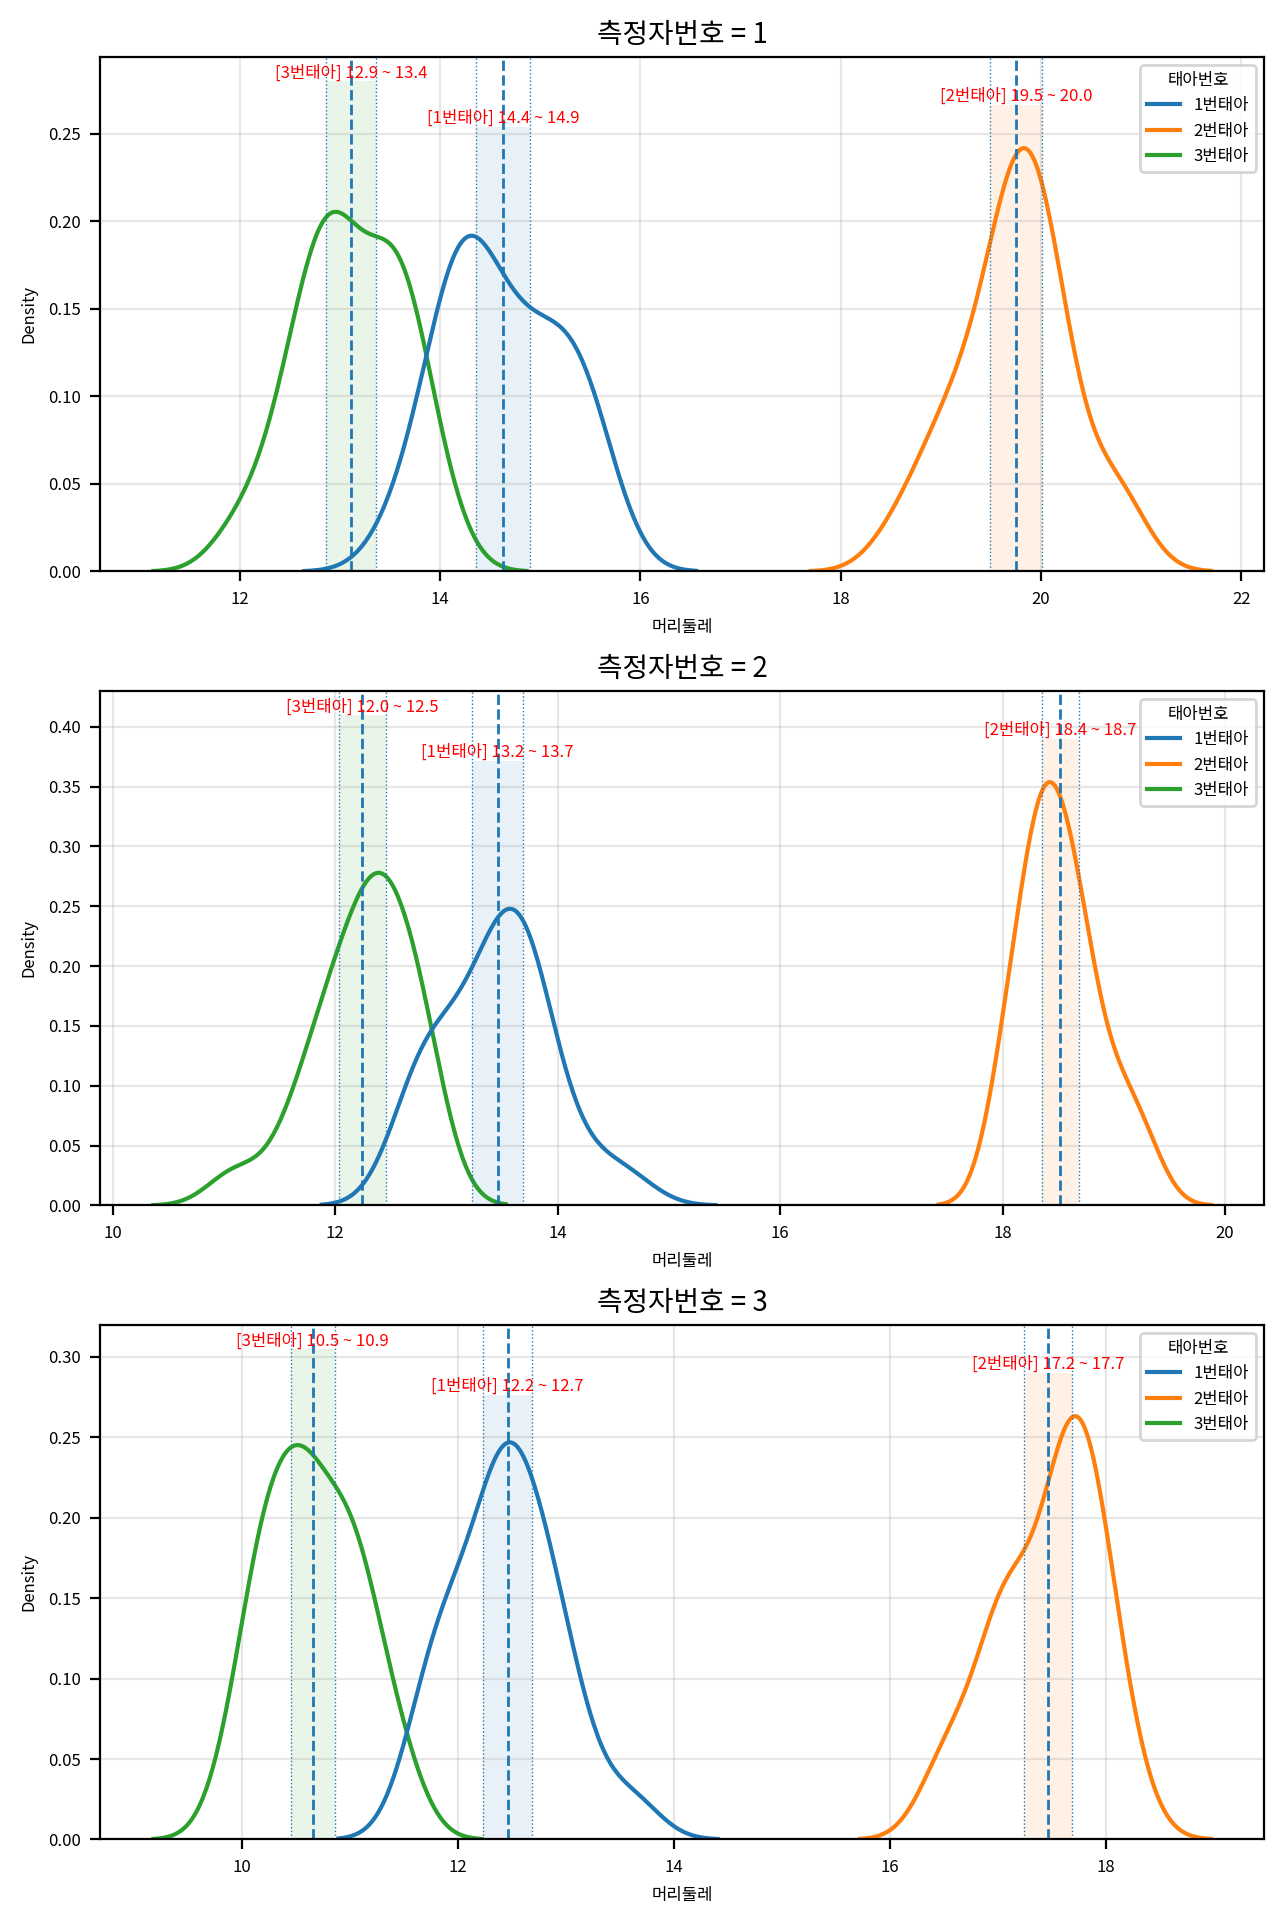

In [6]:
# 확인할 데이터 필드 (수치형):
field = '머리둘레'
# 범주형 필드1:
group_field = '측정자번호'
# 범주형 필드2 (hue):
hue_field = '태아번호'

# 시각화 할 필드만 원본데이터에서 추출:
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화: 캔버스(fig), 도화지(ax) 준비
rows = group_count             # 그래프 행 수
cols = 1                       # 그래프 열 수
width_px = 1280 * cols         # 그래프 가로 크기
height_px = 640 * rows         # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행, 열 수에 따라 리스트 됨:
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기:
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax = ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), 
                    fontsize=10, pad=5)
    
    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        # 신뢰구간 변수 설정:
        max = temp_sub[field].max()                    # 최대값
        dof = len(temp_sub[field]) - 1                 # 자유도
        clevel = 0.95                                  # 신뢰수준
        sp_mean = temp_sub[field].mean()               # 표본평균
        sp_std = temp_sub[field].std(ddof=1)           # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))# 표본표준오차

        cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

        ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

        # 신뢰구간 y값, 평균표시:
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기 (statAnnotator 기능):
        ax[i].text(x = cmin + (cmax-cmin)/2,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment = "center",
                verticalalignment = "bottom",
                fontdict = {"size": 6, "color": "red"})

# 4) 출력:
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

#### (2) 태아별 측정자에 따른 머리둘레 비교:

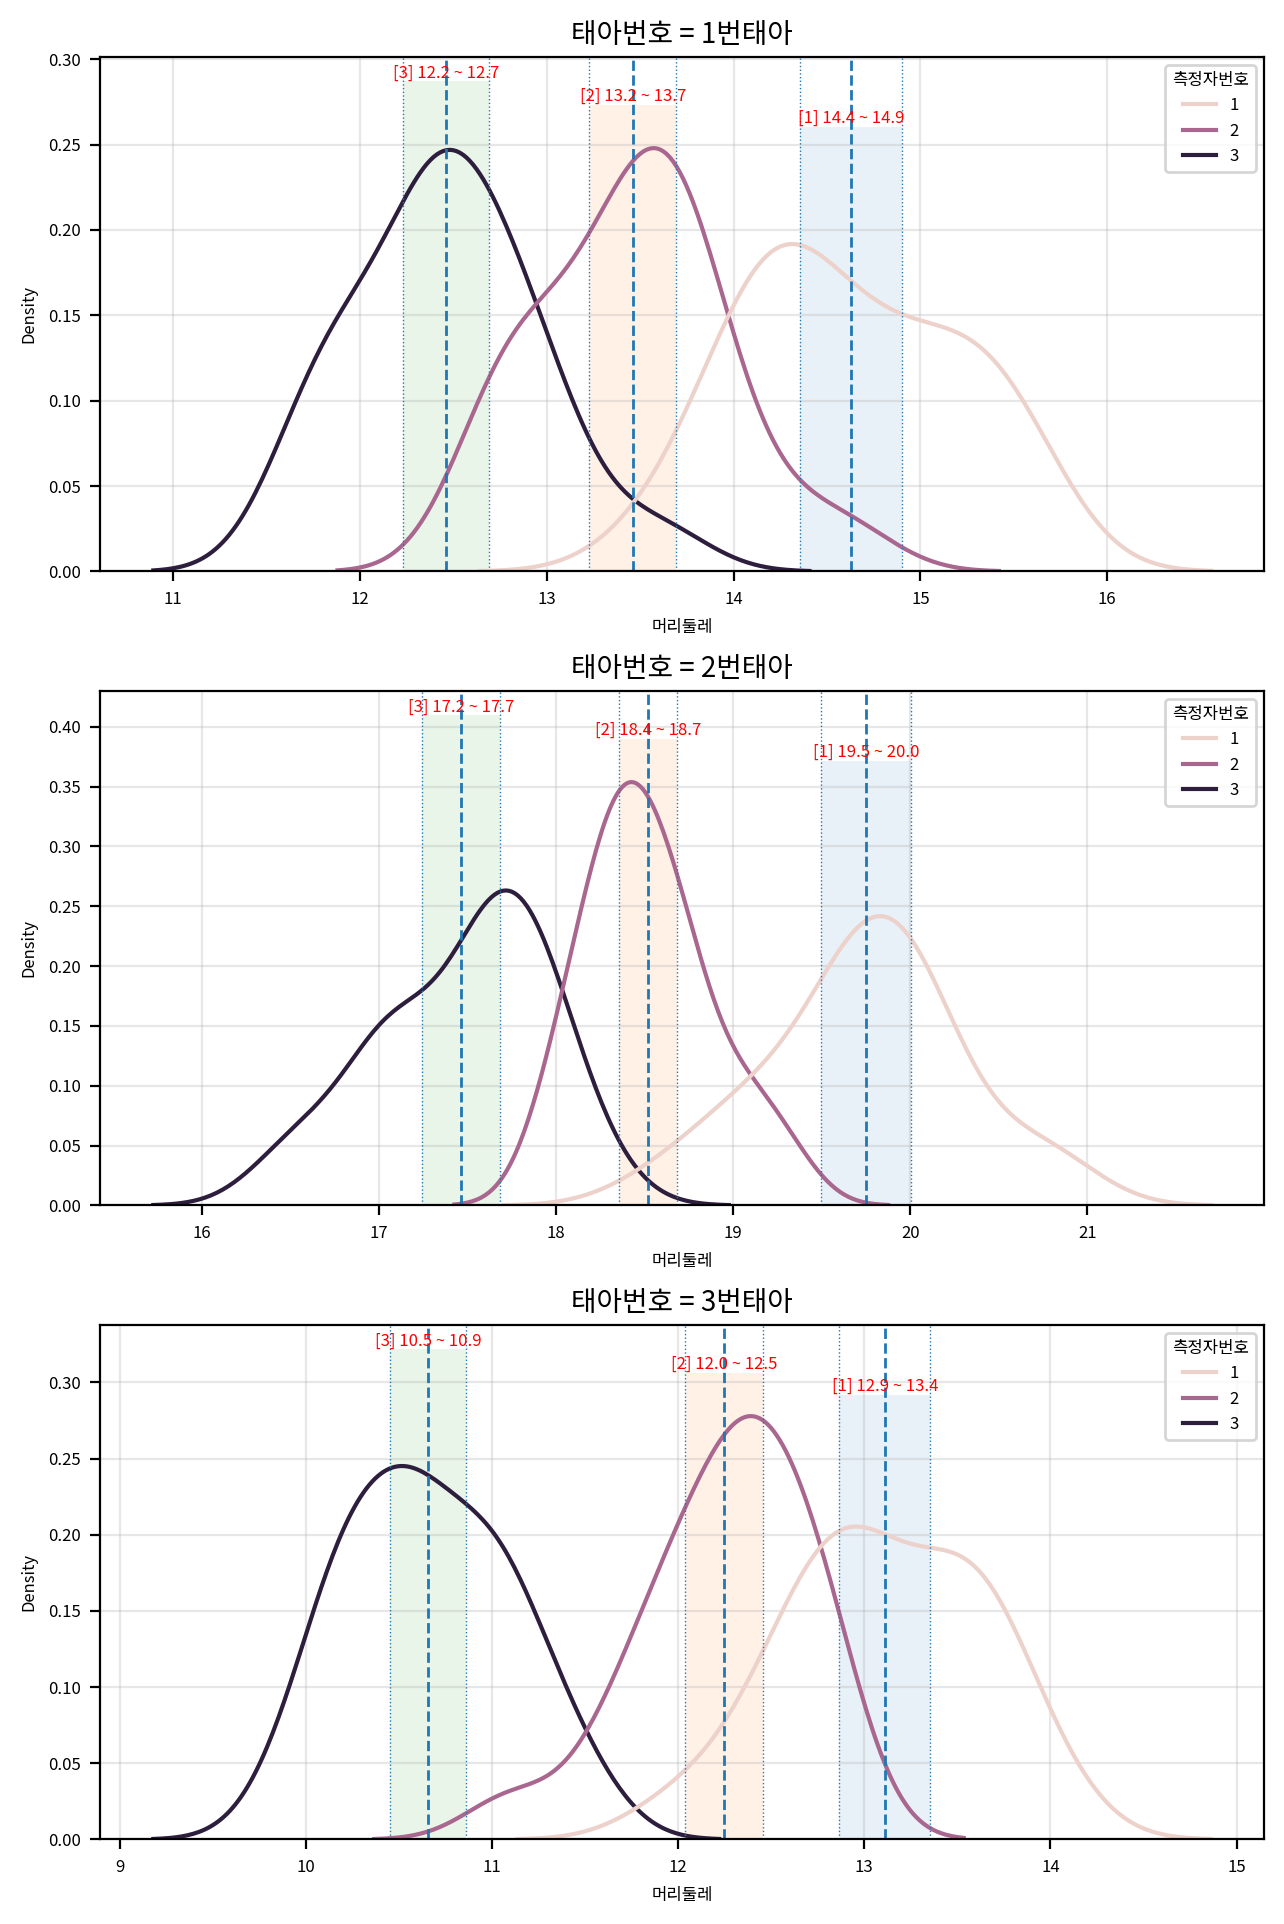

In [7]:
# 확인할 데이터 필드 (수치형):
field = '머리둘레'
# 범주형 필드1:
group_field = '태아번호'
# 범주형 필드2 (hue):
hue_field = '측정자번호'

# 시각화 할 필드만 원본데이터에서 추출:
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화: 캔버스(fig), 도화지(ax) 준비
rows = group_count             # 그래프 행 수
cols = 1                       # 그래프 열 수
width_px = 1280 * cols         # 그래프 가로 크기
height_px = 640 * rows         # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행, 열 수에 따라 리스트 됨:
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기:
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax = ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), 
                    fontsize=10, pad=5)
    
    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        # 신뢰구간 변수 설정:
        max = temp_sub[field].max()                    # 최대값
        dof = len(temp_sub[field]) - 1                 # 자유도
        clevel = 0.95                                  # 신뢰수준
        sp_mean = temp_sub[field].mean()               # 표본평균
        sp_std = temp_sub[field].std(ddof=1)           # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))# 표본표준오차

        cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

        ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

        # 신뢰구간 y값, 평균표시:
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기 (statAnnotator 기능):
        ax[i].text(x = cmin + (cmax-cmin)/2,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment = "center",
                verticalalignment = "bottom",
                fontdict = {"size": 6, "color": "red"})

# 4) 출력:
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

#### (4) 가설검정의 가정 확인:

In [9]:
data = df.copy()
xname = ['측정자번호', '태아번호']  # 범주형 독립변수 2개
yname = '머리둘레'          # 수치형 종속변수 1개

u1 = data[xname[0]].unique() # 명목형변수1의 수준들 종류
u2 = data[xname[1]].unique() # 명목형변수2의 수준들 종류
equal_var_fields = []        # 충족한 등분산성 조건 저장용 
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "fields": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

# 등분산성 검정법 선택:
if normal_dist:
    n = "Bartlett" # : 정규성 충족할 때
    s, p = bartlett(*equal_var_fields) # 모든 컬럼의 데이터 한번에
else:
    n = "Levene's" # :정규성 충족 못할 때
    s, p = levene(*equal_var_fields, 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": n,
    "statistic": s,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
"1, 1번태아",1.885153,0.389623,True
"1, 2번태아",0.290183,0.864943,True
"1, 3번태아",0.408716,0.815171,True
"2, 1번태아",0.454973,0.796533,True
"2, 2번태아",1.442948,0.486035,True
"2, 3번태아",3.862339,0.144979,True
"3, 1번태아",0.666927,0.716438,True
"3, 2번태아",1.463170,0.481146,True
"3, 3번태아",0.846989,0.654755,True


### 5. 분산분석 수행:

In [11]:
xname = ['측정자번호', '태아번호']
yname = '머리둘레'
data = df[xname + [yname]]

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f"→ {source}효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source}효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,측정자번호,159.320778,2,79.660389,336.822068,4.904107e-60,0.797548
1,태아번호,1422.825444,2,711.412722,3008.013241,5.616407e-134,0.972362
2,측정자번호 * 태아번호,2.201222,4,0.550306,2.326816,5.827850e-02,0.051619
3,Residual,40.442500,171,0.236506,NaN,NaN,NaN


→ 측정자번호효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ 태아번호효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ 측정자번호 * 태아번호효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ Residual효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


### 6. 사후검정:

In [12]:
xname = ['측정자번호', '태아번호']  # 명목형 독립변수 2개
yname = '머리둘레'          # 수치형 종속변수 1개
data = df[xname + [yname]]

levels = {}           # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식의 결과 만들기 위해:
for factor in xname:                     # 명목변수 하나씩 꺼냄
    level_count = data[factor].nunique()# 꺼낸 변수의 수준 수 계산
    levels[factor] = level_count         # 딕셔너리에 저장

pvals = {}            # 빈 딕셔너리 만들기
# 예: {'water': 1.3e-20, 'sun': 2.01e-17, 'water*sun': 0.105}:
for index, row in pg_anova.iterrows():  # 행 하나씩 꺼냄
    source_name = row['Source']         # 명목변수 이름
    p_value = row['p-unc']              # 각 명목변수의 p-value
    pvals[source_name] = p_value        # 딕셔너리에 저장

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor] <= 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안함")
        continue

    print(f"- 주효과 유의함 (p={p_val:.3g}) → 사후검정 수행")

    # 결론: hue 그룹 간 평균값 끼리는 유의미한 차이 있다
    # 얼마나? -> 사후검정 ㄱㄱ
    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games-Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리:
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의함 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 불필요")


[측정자번호]
- 주효과 유의함 (p=4.9e-60) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,15.830000,14.741667,1.088333,0.525341,2.071671,0.098702,0.380087
1,1,3,15.830000,13.526667,2.303333,0.525341,4.384456,0.000059,0.781644
2,2,3,14.741667,13.526667,1.215000,0.525341,2.312785,0.056613,0.422358



[태아번호]
- 주효과 유의함 (p=5.62e-134) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1번태아,2번태아,13.516667,18.578333,-5.061667,0.195025,-25.953939,0.000000e+00,-4.841750
1,1번태아,3번태아,13.516667,12.003333,1.513333,0.195025,7.759689,1.915246e-12,1.393082
2,2번태아,3번태아,18.578333,12.003333,6.575000,0.195025,33.713629,0.000000e+00,6.016793



[측정자번호 * 태아번호] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.0583) → 단순주효과 분석 불필요


## #03. 인사이트

### 1. 분석 목적:


### 2. 분산분석 주요 결과:


### 3. 기술통계 및 집단 별 평균 비교


### 4. 사후검정(Post-hoc) 결과


### 5. 최종 결론 요약